# Model Comparison

## Context

With our LightGBM properly trained, we can move on to constructing the hybrid model, that is, subtracting the LightGBM predictions from our Dynamic Harmonic Regression (DHR) forecast. We then compare this hybrid model against the baseline: the standalone DHR model.

**Data Source**
The data used in this notebook was extracted from the notebook *exploratory_analysis/eda-linear.ipynb*

- **Data:** 08/12/2025
- **Localização:** ../data/wrangle

## Set up

### Libraries

In [1]:
## Base
import os
import pickle
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Funções criadas
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parents[1].as_posix())

from src.ts_utils import *

from config import *

In [3]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#003366'])

In [4]:
def fourier(order, period, t):
    comp = pd.DataFrame(index=range(0, t))
    for k in range(1, order+1):
        comp[f'sin_{k}'] = np.sin(2*np.pi*k*comp.index/period)
        comp[f'cos_{k}'] = np.cos(2*np.pi*k*comp.index/period)
        
    return comp

# Data

For this notebook, we will use all available data. Before training the models, we must engineer the necessary features.

In [5]:
df = pd.read_parquet(os.path.join(DATA_PATH_WRANGLE, 'weather_sanitized.parquet'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007 entries, 0 to 4006
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    4007 non-null   datetime64[ns]
 1   tavg    4007 non-null   float64       
 2   prcp    4007 non-null   float64       
 3   snow    4007 non-null   float64       
 4   wspd    4007 non-null   float64       
 5   pres    4007 non-null   float64       
 6   tamp    4007 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 219.3 KB


We begin with the LightGBM features selected in _notebooks/ml_model.ipynb_

In [6]:
light_feature = ['pres_703', 'tamp_404', 'prcp_702', 'tamp_709_diff', 'wspd_718',
       'prcp_411', 'wspd_646', 'tamp_582', 'tamp_523_diff', 'tamp_372',
       'prcp_382', 'tamp_469', 'prcp_703', 'tavg_378_diff', 'wspd_657',
       'tavg_412', 'wspd_416', 'tavg_486_diff', 'wspd_524', 'tamp_397_diff',
       'snow_370_diff', 'pres_389_diff', 'wspd_597', 'pres_440_diff',
       'tavg_682_diff', 'snow_694', 'tavg_695_diff', 'tamp_532_diff',
       'tamp_382', 'wspd_401_diff', 'tavg_728', 'tamp_691_diff']

In [7]:
for feat in light_feature:
    if '_diff' in feat:
        origin, lag, _ = feat.split('_')
        df[feat] = df[origin].shift(int(lag)).diff()
    else:
        origin, lag = feat.split('_')
        df[feat] = df[origin].shift(int(lag))

With the LightGBM features created, we now generate the Fourier features for the Dynamic Harmonic Regression.

In [8]:
df = pd.concat([df, fourier(1, 365, df.shape[0])], axis=1)

Now our dataset contains all the information necessary to compare the models and select the best-performing one.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007 entries, 0 to 4006
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   time           4007 non-null   datetime64[ns]
 1   tavg           4007 non-null   float64       
 2   prcp           4007 non-null   float64       
 3   snow           4007 non-null   float64       
 4   wspd           4007 non-null   float64       
 5   pres           4007 non-null   float64       
 6   tamp           4007 non-null   float64       
 7   pres_703       3304 non-null   float64       
 8   tamp_404       3603 non-null   float64       
 9   prcp_702       3305 non-null   float64       
 10  tamp_709_diff  3297 non-null   float64       
 11  wspd_718       3289 non-null   float64       
 12  prcp_411       3596 non-null   float64       
 13  wspd_646       3361 non-null   float64       
 14  tamp_582       3425 non-null   float64       
 15  tamp_523_diff  3483 n

Since our target feature is heteroscedastic and the residuals from our Dynamic Harmonic Regression are not normally distributed, we cannot rely on the theoretical confidence interval, even if we choose the benchmark model. For this reason, we applied a method known as empirical prediction intervals, which uses forecast residuals from previous predictions to empirically construct the confidence interval.

To do this, we split the data into three parts: a training set with 7 years of data, a calibration set with 2 years used both for model comparison and for constructing the empirical intervals, and a test set of nearly 2 years.

In [10]:
df_train = df.head(7 * 365).copy()
df_calib = df.head(9 * 365).tail(2 * 365).copy()
df_test = df.tail(df.shape[0] - (9 * 365)).copy()

df_train.shape, df_calib.shape, df_test.shape

((2555, 41), (730, 41), (722, 41))

In [11]:
df_train['time'].min(), df_train['time'].max()

(Timestamp('2014-11-21 00:00:00'), Timestamp('2021-11-18 00:00:00'))

In [12]:
df_calib['time'].min(), df_calib['time'].max()

(Timestamp('2021-11-19 00:00:00'), Timestamp('2023-11-18 00:00:00'))

In [13]:
df_test['time'].min(), df_test['time'].max()

(Timestamp('2023-11-19 00:00:00'), Timestamp('2025-11-09 00:00:00'))

# Boosting
Before moving on to the comparison between models, we must first generate the predictions from our pre-saved LightGBM model.

In [14]:
with open('lightgbm_model.pkl', 'rb') as f:
    tree_model = pickle.load(f)
tree_model

,boosting_type,'gbdt'
,num_leaves,2
,max_depth,-1
,learning_rate,0.0795599077344849
,n_estimators,224
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,16


In [15]:
df_train['light_pred'] = 0
df_calib['light_pred'] = tree_model.predict(df_calib[light_feature])
df_test['light_pred'] = tree_model.predict(df_test[light_feature])
df['light_pred'] = tree_model.predict(df[light_feature])

# Expanding cross-validation

In this section, we use expanding cross-validation on two years of data to evaluate the performance of each model and determine which one performs best for this specific problem. Our comparison metric is Mean Absolute Error (MAE).

In [16]:
df_ecv = pd.concat([df_train, df_calib], ignore_index=True).sort_values('time')
X = df_ecv[["sin_1", "cos_1", "light_pred"]].copy()
y = df_ecv['tavg'].copy()

In [17]:
error = {'DHR': [], 'Boost': [], 'DHRXL': []}

for i in tqdm(range(-2*365, -365), position=0, leave=True):
    # Sets
    X_train = X[:i]
    X_valid = X[i:i+365]
    y_train = y[:i]
    y_valid = y[i:i+365]
    
    # DHR model
    ## Train Model
    DHR = ARIMA(y_train, X_train[["sin_1", "cos_1"]], order=(2,0,2)).fit()
    
    ## Forecast
    DHR_forecast = DHR.forecast(365, exog=X_valid[["sin_1", "cos_1"]])
    error['DHR'].append(abs(DHR_forecast - y_valid).reset_index(drop=True))

    # Boosting model
    Boost_forecast = DHR_forecast - X_valid['light_pred']
    error['Boost'].append(abs(Boost_forecast - y_valid).reset_index(drop=True))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [05:43<00:00,  1.06it/s]


In [18]:
dhr_mae = pd.concat(error['DHR'], axis=1, ignore_index=True).mean(axis=1)
boost_mae = pd.concat(error['Boost'], axis=1, ignore_index=True).mean(axis=1)

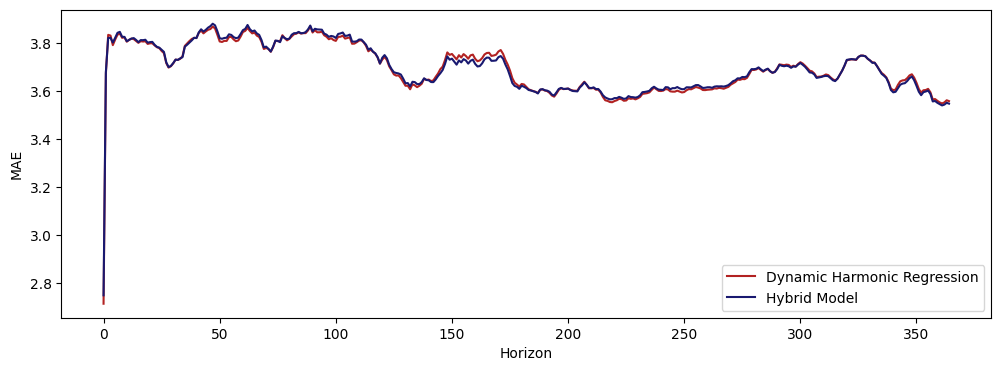

In [19]:
plt.figure(figsize=(12, 4))

sns.lineplot(x=dhr_mae.index, y=dhr_mae, c='firebrick', label='Dynamic Harmonic Regression')
sns.lineplot(x=boost_mae.index, y=boost_mae, c='midnightblue', label='Hybrid Model')

plt.xlabel('Horizon')
plt.ylabel('MAE')


plt.show()

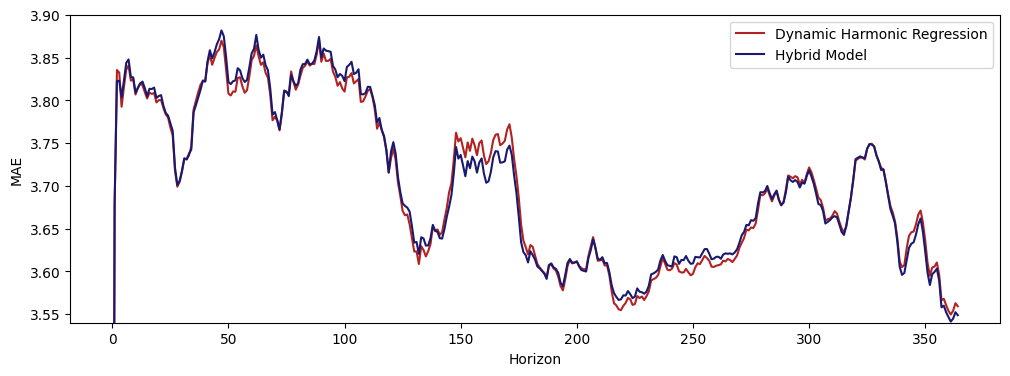

In [20]:
plt.figure(figsize=(12, 4))

sns.lineplot(x=dhr_mae.index, y=dhr_mae, c='firebrick', label='Dynamic Harmonic Regression')
sns.lineplot(x=boost_mae.index, y=boost_mae, c='midnightblue', label='Hybrid Model')

plt.xlabel('Horizon')
plt.ylabel('MAE')

plt.ylim(3.54, 3.9)


plt.show()

Based on the graph above, it is not clear which model performed better. Therefore, we calculated the area under the lines to identify the model with the smallest value.

In [21]:
np.trapezoid(dhr_mae), np.trapezoid(boost_mae)

(np.float64(1347.1529074449184), np.float64(1347.430538665588))

The model that presented the smallest area was the Dynamic Harmonic Regression. However, it is well known that this model produces highly accurate short-term forecasts but loses precision in longer-term forecasts.

In [31]:
np.trapezoid(dhr_mae.tail(255)), np.trapezoid(boost_mae.tail(255))

(np.float64(928.2947351535197), np.float64(927.960806893469))

When we consider only the last 255 values, the hybrid model shows better performance, even if only slightly. Since our main objective is to improve long-term forecasts, this model was selected.

# Confidence Interval

With the model selected, we can proceed to creating the confidence intervals to finalize the average temperature forecast.

In [23]:
dic_resid = {}

for step, i in tqdm(enumerate(range(-2*365, 0)), position=0, total=2*365, leave=True):
    
    # Sets
    X_train = X[:i]
    X_valid = X[i:i+365] if i < -365 else X[i:]
    y_train = y[:i]
    y_valid = y[i:i+365] if i < -365 else y[i:]
    
    # DHR model
    ## Train Model
    DHR = ARIMA(y_train, X_train[["sin_1", "cos_1"]], order=(2,0,2)).fit()
    
    ## Forecast 
    steps_ahead = 365 if i < -365 else -i
    DHR_forecast = DHR.forecast(steps_ahead, exog=X_valid[["sin_1", "cos_1"]]) 
    dic_resid[step] = (DHR_forecast  - X_valid['light_pred']- y_valid).reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 730/730 [14:00<00:00,  1.15s/it]


In [24]:
df_resid = pd.DataFrame(dic_resid).T
df_resid.head()

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,-2.847635,-4.221321,-3.455473,4.635313,2.061172,-3.279355,-1.226742,6.197997,0.964783,2.589403,...,-7.686073,-12.018230,-0.383508,6.041359,5.748602,5.412851,4.435706,4.807358,6.156260,9.744521
1,-2.537846,-2.576697,5.218320,2.502311,-2.926696,-0.938916,6.434812,1.160378,2.751378,1.883830,...,-12.008585,-0.373841,6.051045,5.758306,5.422571,4.445440,4.817103,6.166016,9.754285,11.583629
2,-1.024459,6.025341,3.035910,-2.524539,-0.619002,6.694363,1.372428,2.925072,2.026273,-2.628336,...,-0.372638,6.052259,5.759534,5.423812,4.446696,4.818374,6.167304,9.755590,11.584953,9.431464
3,6.508754,3.288043,-2.357327,-0.492561,6.795341,1.454740,2.992699,2.082043,-2.582231,-3.350885,...,6.054769,5.762051,5.426335,4.449225,4.820909,6.169844,9.758134,11.587501,9.434016,2.736399
4,-2.272945,-5.255095,-2.413041,5.344052,0.296614,2.049628,1.308226,-3.219307,-3.876475,-7.455312,...,5.741007,5.405226,4.428054,4.799679,6.148557,9.736795,11.566111,9.412579,2.714918,0.071852


In [36]:
interval_range = df_resid.head(365).apply(lambda x: np.quantile(x, [0.025, 0.975])).T
interval_range.columns = ['lower', 'upper']

With the ranges created we can apply it in the data

In [37]:
df_ecv_time_index = df_ecv.set_index('time')
df_ecv_time_index.index.freq='D'

DHR = ARIMA(df_ecv_time_index['tavg'], df_ecv_time_index[["sin_1", "cos_1"]], order=(2,0,2)).fit()
forecast = DHR.forecast(365, exog=df_test[["sin_1", "cos_1"]].head(365)).reset_index()
forecast['lower_y'] = forecast['predicted_mean'] + interval_range['lower']
forecast['upper_y'] = forecast['predicted_mean'] + interval_range['upper']

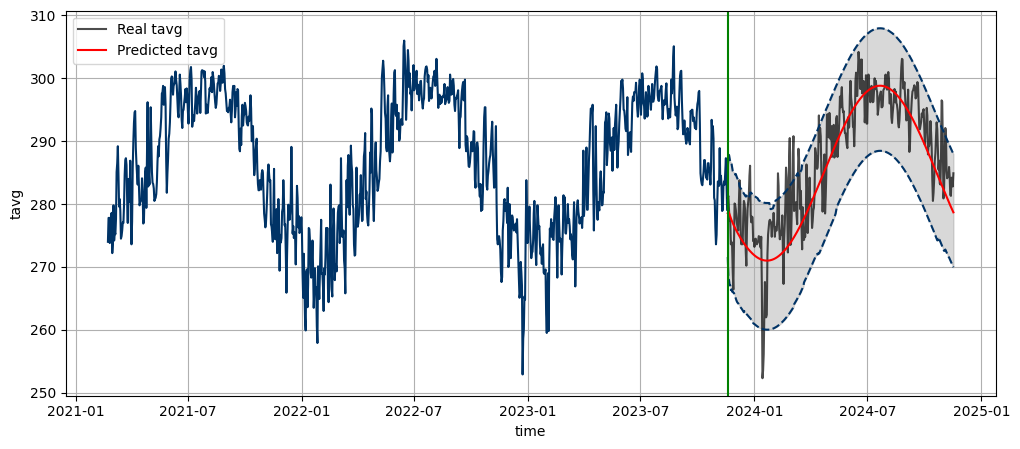

In [39]:
plt.figure(figsize=(12, 5))

sns.lineplot(x='time', y='tavg', data=df_ecv.tail(1000))
sns.lineplot(x='time', y='tavg', data=df_test.head(365), color='black', alpha=0.7, label='Real tavg')

sns.lineplot(x='index', y='predicted_mean', data=forecast, color='r', label='Predicted tavg')
sns.lineplot(x='index', y='lower_y', data=forecast, linestyle='--')
sns.lineplot(x='index', y='upper_y', data=forecast, linestyle='--')
plt.fill_between(forecast['index'], y1=forecast['lower_y'], y2=forecast['upper_y'], color='grey',alpha=0.3)

plt.axvline(x=forecast['index'][0], color='g')


plt.grid()
plt.show()

Above, we present the tavg forecast with its confidence interval

In [28]:
all_resid = {}

for step, i in tqdm(enumerate(range(-df_test.shape[0], 0)), position=0, total=df_test.shape[0], leave=True):
    
    # Sets
    X_train = df[:i][["sin_1", "cos_1", "light_pred"]]
    X_valid = df[i:][["sin_1", "cos_1", "light_pred"]]
    y_train = df[:i]['tavg']
    y_valid = df[i:]['tavg']
    
    # DHR model
    ## Train Model
    DHR = ARIMA(y_train, X_train[["sin_1", "cos_1"]], order=(2,0,2)).fit()
    
    ## Forecast 
    DHR_forecast = DHR.forecast(-i, exog=X_valid[["sin_1", "cos_1"]]) 
    all_resid[step] = (DHR_forecast - y_valid - X_valid['light_pred']).reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 722/722 [20:43<00:00,  1.72s/it]


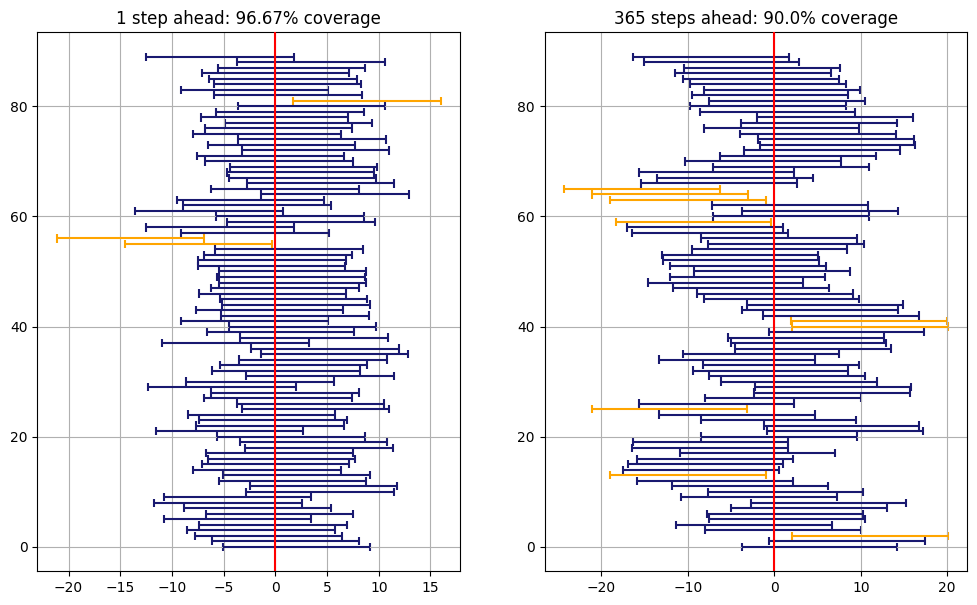

In [79]:
df_all_resid = pd.DataFrame(all_resid)
n=90
df_cover = pd.DataFrame({'min_0': [interval_range['lower'].iloc[0] - res for res in df_all_resid.iloc[0][range(0, n)]],
                             'max_0': [interval_range['upper'].iloc[0] - res for res in df_all_resid.iloc[0][range(0, n)]],
                             'min_365': [interval_range['lower'].iloc[364] - res for res in df_all_resid.iloc[364][range(0, n)]],
                             'max_365': [interval_range['upper'].iloc[364] - res for res in df_all_resid.iloc[364][range(0, n)]]})

df_cover['color_365'] = df_cover['color_0'] = 'midnightblue'
df_cover.loc[(df_cover['min_0'] > 0) | (df_cover['max_0'] < 0), 'color_0'] = 'orange'
df_cover.loc[(df_cover['min_365'] > 0) | (df_cover['max_365'] < 0), 'color_365'] = 'orange'

cover_0 = 100 * (df_cover['color_0'] == 'midnightblue').sum() / df_cover.shape[0]
cover_365 = 100 * (df_cover['color_365'] == 'midnightblue').sum() / df_cover.shape[0]

fig, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].axvline(x=0, color='r', zorder=3)
ax[1].axvline(x=0, color='r', zorder=3)

for i, row in df_cover.iterrows():
    ax[0].hlines(y=i, xmin=row.iloc[0], xmax=row.iloc[1], color=row.iloc[5])
    ax[1].hlines(y=i, xmin=row.iloc[2], xmax=row.iloc[3], color=row.iloc[4])


ax[0].scatter(x=df_cover['min_0'], y=df_cover.index, marker='|', color=df_cover['color_0'])
ax[0].scatter(x=df_cover['max_0'], y=df_cover.index, marker='|', color=df_cover['color_0'])
ax[1].scatter(x=df_cover['min_365'], y=df_cover.index, marker='|', color=df_cover['color_365'])
ax[1].scatter(x=df_cover['max_365'], y=df_cover.index, marker='|', color=df_cover['color_365'])


ax[0].set_title(f"1 step ahead: {round(cover_0, 2)}% coverage")
ax[1].set_title(f"365 steps ahead: {round(cover_365, 2)}% coverage")

ax[0].grid()
ax[1].grid()

plt.show()
#sns.


Our data are heteroscedastic, which makes confidence interval construction more challenging. Because of this, we had to use an alternative approach: empirical prediction intervals. With this in mind, the figure above shows the coverage of this method for the first and last forecast steps, using a 95% confidence level.

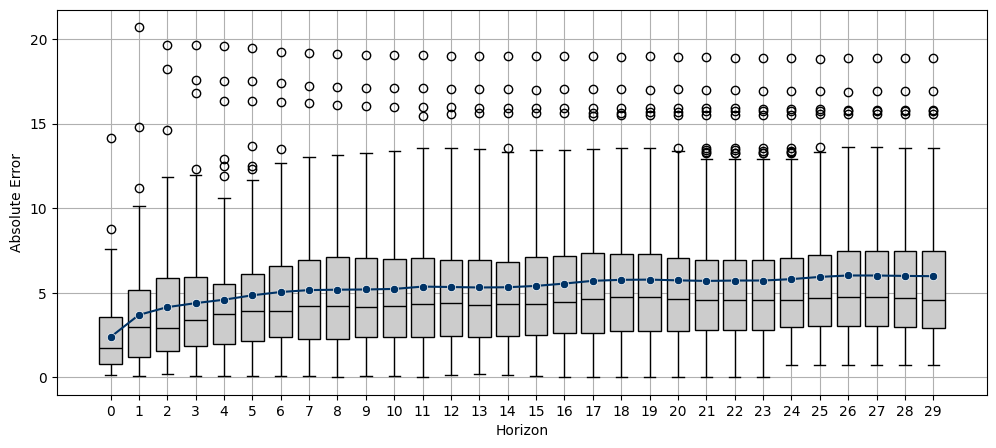

In [80]:
df_resid_box = df_all_resid[range(0, n)].head(30).T.melt()
df_resid_box['AE'] = abs(df_resid_box['value'])

plt.figure(figsize=(12, 5))

sns.boxplot(x='variable', y='AE', data=df_resid_box, color='0.8', linewidth=1, linecolor='black')
sns.lineplot(x='variable', y='AE', data=df_resid_box.groupby('variable').mean().reset_index(), zorder=2)
sns.scatterplot(x='variable', y='AE', data=df_resid_box.groupby('variable').mean().reset_index(), zorder=3)

plt.ylabel("Absolute Error")
plt.xlabel("Horizon")
plt.grid()
plt.show()

With this, we present the absolute error distribution, with the MAE indicated by the blue line.